<a href="https://colab.research.google.com/github/virf96/Analisis_Texto/blob/master/Sentiment_analysis_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Redes neuronales recursivas (RNNs) para análisis de opinión.

### Procesamiento del Lenguaje Natural


**Pablo Martínez Olmos, Vanessa Gómez Verdejo, Emilio Parrado Hernández**

Departamento de Teoría de la Señal y Comunicaciones

**Universidad Carlos III de Madrid**

<img src='http://www.tsc.uc3m.es/~emipar/BBVA/INTRO/img/logo_uc3m_foot.jpg' width=400 />

En este notebook vamos a comparar un modelo basado en word embeddings-RNN-MLP con técnicas ya conocidas de clasificación de documentos:

1) TF-IDF + regresión logística
2) Promedio de word embeddings + k-NN

Además, para mostrar que el cuello de botella está en la representación del texto y no tanto en el clasificador, mostraremos también cómo un clasificador de tipo MLP no es capaz de mejorar las dos soluciones anteriores. Como mostraremos, el procesamiento secuencial de una RNN es clave. 

Utilizaremos [Pytorch](https://pytorch.org/) para construir y entrenar la distintas redes neuronales. Para una introducción detallada de Pytorch, se recomiendan los siguientes tutoriales:

* [Pytorch official website](https://pytorch.org/tutorials/beginner/basics/intro.html)

* [University of Amsterdam (UvA) Deep Learning Tutorials](https://uvadlc-notebooks.readthedocs.io/en/latest/index.html)


Como base de datos recuperaremos la base de datos [Finantial Phrase Bank](https://www.researchgate.net/profile/Pekka-Malo/publication/251231364_FinancialPhraseBank-v10/data/0c96051eee4fb1d56e000000/FinancialPhraseBank-v10.zip) contiene cerca de 5000 oraciones extraídas de textos de noticias financieras:


>*This release of the financial phrase bank covers a collection of 4840 sentences. The selected collection of phrases was annotated by 16 people with adequate background knowledge on financial markets. Three of the annotators were researchers and the remaining 13 annotators were master’s students at Aalto University School of Business with majors primarily in finance, accounting, and economics.*
>
>*The objective of the phrase level annotation task was to classify each example sentence into a positive, negative or neutral category by considering only the information explicitly available in the given sentence. Since the study is focused only on financial and economic domains, the annotators were asked to consider the sentences from the view point of an investor only; i.e. whether the news may have positive, negative or neutral influence on the stock price. As a result, sentences which have a sentiment that is not relevant from an economic or financial perspective are considered neutral.*

Vamos a cargar la base de datos y procederemos al pre-procesado. Esta parte y el entrenamiento de los baselines son idénticas al código que vimos en la sesión 5.





In [ ]:
import numpy as np
import pandas as pd
import torch 
import spacy

import gensim
from gensim.models import TfidfModel
from gensim.matutils import corpus2dense, corpus2csc

%matplotlib inline
%config InlineBackend.figure_format = 'retina' 
import matplotlib.pyplot as plt

In [ ]:
#from google.colab import files

#uploaded = files.upload()

In [ ]:
with open("Sentences.txt", "r", encoding="ISO-8859-1") as sentences:
    lines = sentences.readlines()

In [ ]:
print(lines[0])

According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .@neutral



Codificamos las etiquetas con 0 (neutra), 1 (negativa) y 2 (positiva)

In [ ]:
phrases = [l.split('@')[0] for l in lines]
opinions = [l.split('@')[1] for l in lines]


def code_opinion(l):
    
    d = 0
    
    if (l=='negative\n'):
        
        d = 1
        
    elif (l=='positive\n'):
        
        d = 2
        
    return d

labels = np.array([code_opinion(l) for l in opinions])
    

In [ ]:
df = pd.DataFrame({"Phrase":phrases,
                  "Opinion":opinions})

df

,Phrase,Opinion
0,"According to Gran , the company has no plans t...",neutral\n
1,With the new production plant the company woul...,positive\n
2,"For the last quarter of 2010 , Componenta 's n...",positive\n
3,"In the third quarter of 2010 , net sales incre...",positive\n
4,Operating profit rose to EUR 13.1 mn from EUR ...,positive\n
...,...,...
5712,Operating result for the 12-month period decre...,negative\n
5713,HELSINKI Thomson Financial - Shares in Cargote...,negative\n
5714,LONDON MarketWatch -- Share prices ended lower...,negative\n
5715,Operating profit fell to EUR 35.4 mn from EUR ...,negative\n


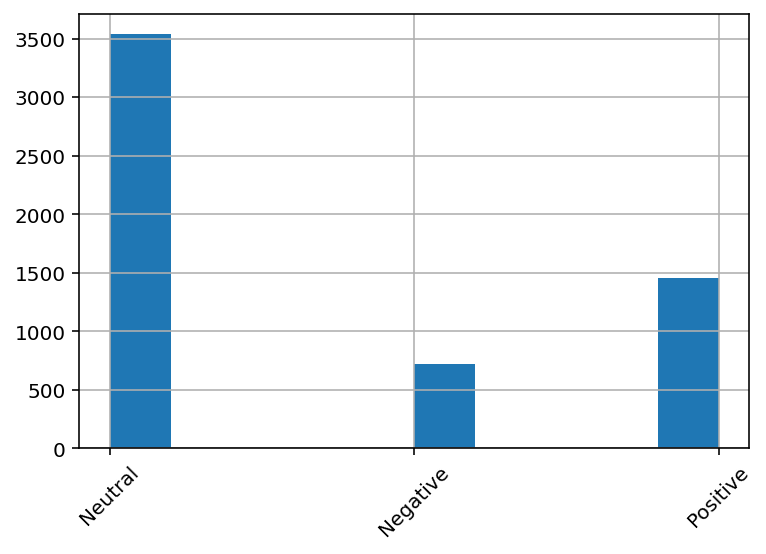

In [ ]:
fig,ax = plt.subplots(1,1)

ax.hist(labels)
ax.set_xticks([0,1,2])
ax.set_xticklabels(['Neutral','Negative','Positive'],rotation=45)
ax.grid()


Pre-procesamos con spaCy el texto ...

In [ ]:
nlp = spacy.load("en_core_web_lg")

# Desabilitamos procesos que no vamos a utilizar

list_processes = ["lemmatizer","tagger","parser","ner","attribute_ruler"]

for l in list_processes:
    nlp.disable_pipe(l) 
    


In [ ]:
docs = [nlp(c) for c in phrases]

def normalize(doc):
    
    return [w for w in doc if not w.is_stop and w.has_vector and not w.is_punct]

# eliminamos stopping words, puntuaciones y tokens sin word embedding
norm_docs = [normalize(d) for d in docs]

# Pasamos a modo texto
norm_docs_text = [[w.text.lower() for w in d] for d in norm_docs]

# Volvemos a crear una lista de objetos spacy.Doc y extraemos la media de los word embeddings ...
W = np.array([nlp(' '.join(d)).vector for d in norm_docs_text])

print(f"La dimensión de la matriz de embeddings es {W.shape[0]} x {W.shape[1]}")


La dimensión de la matriz de embeddings es 5717 x 300


Filtrado básico del diccionario ...

In [ ]:
# Diccionario y TF-IDF

D = gensim.corpora.Dictionary(norm_docs_text)

no_below = 10 #Minimum number of documents to keep a term in the dictionary
no_above = .8 #Maximum proportion of documents in which a term can appear to be kept in the dictionary

D.filter_extremes(no_below=no_below,no_above=no_above)

corpus_bow = [D.doc2bow(doc) for doc in norm_docs_text]

model = TfidfModel(corpus_bow)  

corpus_tfidf = model[corpus_bow]

n_tokens = len(D)
num_docs = len(corpus_bow)

# Convert TFIDF representacion
C = corpus2dense(corpus_tfidf, num_terms=n_tokens, num_docs=num_docs).T

print(f"La dimensión de la matriz TF-IDF es {C.shape[0]} x {C.shape[1]}")

La dimensión de la matriz TF-IDF es 5717 x 1186


In [ ]:
from sklearn.model_selection import train_test_split

labels_bin = labels.copy()

labels_bin[labels_bin==2] = 0 

idx_data = np.arange(0,C.shape[0],1)

# Separamos train de test
idx_train, idx_test, y_train, y_test = train_test_split(idx_data, labels_bin, test_size=0.2, random_state=0)

# Separamos train de val
idx_train, idx_val, y_train, y_val = train_test_split(idx_train, y_train, test_size=0.2, random_state=0)

acc_baseline_train = np.sum(y_train==0)/y_train.shape[0]

print(f"El % de etiquetas correctas del clasificador baseline es {acc_baseline_train}")

El % de etiquetas correctas del clasificador baseline es 0.86960087479497


# 1. Clasificación binaria

Obtenidas las dos representaciones vectoriales por documento, vamos a entrenar un RL **binario** para clasificar cada oración entre negativa (1) y neutral/positiva (0). Observe que la base de datos está muy desbalanceada.


## 1.1 Clasificación TF-IDF + LR

In [ ]:
from sklearn.linear_model import LogisticRegression as LR
from sklearn.model_selection import GridSearchCV

rango_C = np.logspace(-3, 3, 20)  # Rango C en escala logarítmica (base 10). Esto es, 20 puntos desde 10^3, a 10^3.
diccionario_parametros = [{'C': rango_C}]   
nfold = 10 # Número de particiones train/validación

""" Ajusto C por validación cruzada
El optimizador por defecto ('lbfgs') no acepta regularización l1. 
Usamos 'liblinear' siguiendo las recomendaciones de la librería.
"""
LR_with_CV  = GridSearchCV(estimator=LR(penalty='l1',max_iter=1e08,solver='liblinear'),
                                  param_grid=diccionario_parametros,cv=nfold)
# Entrenar el modelo
LR_with_CV.fit(C[idx_train,:],y_train)   

print("El mejor parámetro C es {0:.2f}".format(LR_with_CV.best_params_['C']))
                        
# Score de claisficación en train/test
accuracy_train = LR_with_CV.score(C[idx_train,:],y_train)   
accuracy_test = LR_with_CV.score(C[idx_test,:],y_test)  

print("Accuracy train {0:.2f}%. Accuracy test {1:.2f}%\n".format(accuracy_train*100, accuracy_test*100))


El mejor parámetro C es 12.74
Accuracy train 99.29%. Accuracy test 94.49%



## 1.2 Clasificación media WE + LR

In [ ]:
from sklearn.preprocessing import StandardScaler

# A diferencia de TF-IDF, en este caso normalizamos las características (columnas de W)

standarize = StandardScaler().fit(W[idx_train,:])   

W_train = standarize.transform(W[idx_train,:])
W_test = standarize.transform(W[idx_test,:])


rango_C = np.logspace(-3, 3, 20)  # Rango C en escala logarítmica (base 10). Esto es, 20 puntos desde 10^3, a 10^3.
diccionario_parametros = [{'C': rango_C}]   
nfold = 10 # Número de particiones train/validación

emb_LR_with_CV = GridSearchCV(estimator=LR(penalty='l2',max_iter=1e04),param_grid=diccionario_parametros,cv=nfold)
# Entrenar el modelo
emb_LR_with_CV.fit(W_train,y_train)   

print("El mejor parámetro C es {0:.2f}".format(emb_LR_with_CV.best_params_['C']))
                        
# Score de claisficación en train/test
accuracy_train = emb_LR_with_CV.score(W_train,y_train)   
accuracy_test = emb_LR_with_CV.score(W_test,y_test)  

print("Accuracy train {0:.2f}%. Accuracy test {1:.2f}%\n".format(accuracy_train*100, accuracy_test*100))


El mejor parámetro C es 0.34
Accuracy train 94.45%. Accuracy test 92.74%



## 1.3 Clasificación media WE + k-NN

Normalizamos por filas para emular distancia coseno ...

In [ ]:
norms = np.linalg.norm(W,axis=1)

norms[norms<1e-6] = 1e-6

W_ = W/norms.reshape([-1,1])

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

# Entrenamiento k-NN con validación de vecinos y ponderación de distancias
K_max = 15
rango_K = np.arange(1, K_max+1)
nfold = 10
# Define a dictionary with the name of the parameters to explore as a key and the ranges to explores as value
diccionario_parametros = [{'n_neighbors': rango_K,'weights':['uniform','distance']}]

# Validación cruzada con GridSearchCV
knn = GridSearchCV(estimator=KNeighborsClassifier( ), param_grid=diccionario_parametros,cv=nfold)
# Entrenamiento
knn.fit(W_[idx_train,:],y_train)
# Test
accuracy_train_knn = knn.score(W_[idx_train,:],y_train)
accuracy_test_knn = knn.score(W_[idx_test,:],y_test)

print("El número de vecinos seleccionado es k={0:d}".format(knn.best_params_['n_neighbors']))
print("Accuracy train {0:.2f}%. Accuracy test {1:.2f}%\n".format(accuracy_train_knn*100, accuracy_test_knn*100))

El número de vecinos seleccionado es k=10
Accuracy train 100.00%. Accuracy test 93.79%



## 1.4 Representación curvas ROC y PR

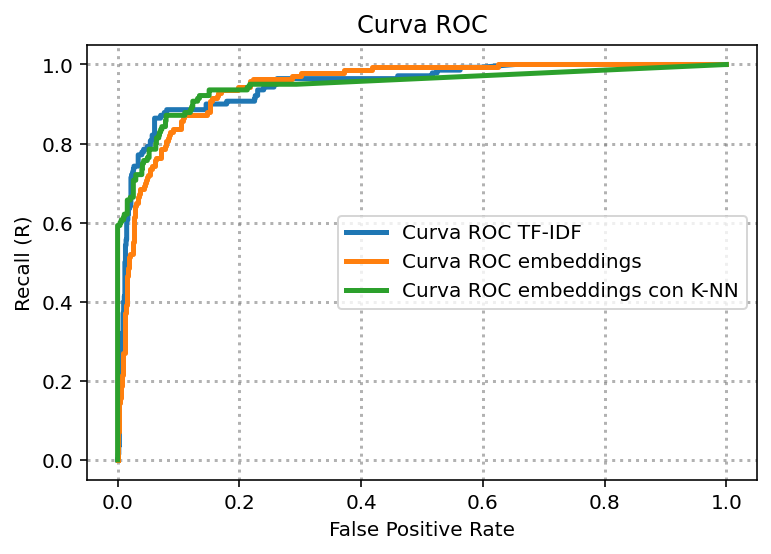

El área bajo la curva ROC de TF-IDF es 0.9481502561183837
El área bajo la curva ROC de embeddings es 0.9464428002276608
El área bajo la curva ROC de embeddings con K-NN es 0.9447958167330679


In [ ]:
from sklearn import metrics

fpr, recall, thresholds = metrics.roc_curve(y_test, LR_with_CV.predict_proba(C[idx_test,:])[:,1], pos_label=1) 
fpr2, recall2, thresholds = metrics.roc_curve(y_test, emb_LR_with_CV.predict_proba(W_test)[:,1], pos_label=1) 
fpr3, recall3, thresholds = metrics.roc_curve(y_test, knn.predict_proba(W_[idx_test,:])[:,1], pos_label=1) 

fig,ax = plt.subplots()
plt.plot(fpr,recall,lw=2.5,label='Curva ROC TF-IDF')
plt.plot(fpr2,recall2,lw=2.5,label='Curva ROC embeddings')
plt.plot(fpr3,recall3,lw=2.5,label='Curva ROC embeddings con K-NN')
plt.legend(loc=7)
plt.grid(b=True, which='major', color='gray', alpha=0.6, linestyle='dotted', lw=1.5)
plt.xlabel('False Positive Rate')
plt.ylabel('Recall (R)')
plt.title('Curva ROC')
plt.show()

area_roc_tf_idf = metrics.roc_auc_score(y_test, LR_with_CV.predict_proba(C[idx_test,:])[:,1])
area_roc_embbedings = metrics.roc_auc_score(y_test, emb_LR_with_CV.predict_proba(W_test)[:,1])
area_roc_embbedings_knn = metrics.roc_auc_score(y_test, knn.predict_proba(W_[idx_test,:])[:,1])

print(f"El área bajo la curva ROC de TF-IDF es {area_roc_tf_idf}")
print(f"El área bajo la curva ROC de embeddings es {area_roc_embbedings}")
print(f"El área bajo la curva ROC de embeddings con K-NN es {area_roc_embbedings_knn}")

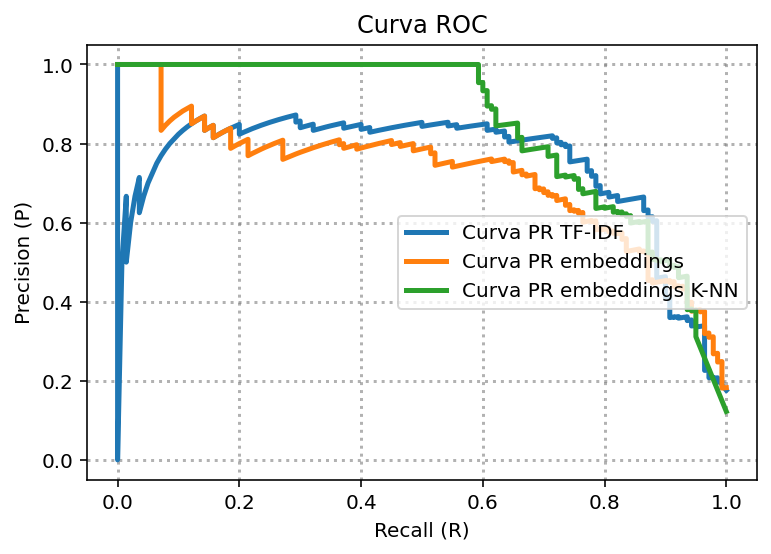

El área bajo la curva PR de TF-IDF es 0.7461687239536652
El área bajo la curva PR de embeddings es 0.7206166463724953
El área bajo la curva PR de embeddings con k-NN es 0.841888278880105


In [ ]:
P, R, thresholds = metrics.precision_recall_curve(y_test, LR_with_CV.predict_proba(C[idx_test,:])[:,1], pos_label=1) 
P2, R2, thresholds = metrics.precision_recall_curve(y_test, emb_LR_with_CV.predict_proba(W_test)[:,1], pos_label=1) 
P3, R3, thresholds = metrics.precision_recall_curve(y_test, knn.predict_proba(W_[idx_test,:])[:,1], pos_label=1) 

fig,ax = plt.subplots()
plt.plot(R,P,lw=2.5,label='Curva PR TF-IDF')
plt.plot(R2,P2,lw=2.5,label='Curva PR embeddings')
plt.plot(R3,P3,lw=2.5,label='Curva PR embeddings K-NN')
plt.legend(loc=7)
plt.grid(b=True, which='major', color='gray', alpha=0.6, linestyle='dotted', lw=1.5)
plt.xlabel('Recall (R)')
plt.ylabel('Precision (P)')
plt.title('Curva ROC')
plt.show()

area_pr_tf_idf = metrics.average_precision_score(y_test, LR_with_CV.predict_proba(C[idx_test,:])[:,1])
area_pr_embbedings = metrics.average_precision_score(y_test, emb_LR_with_CV.predict_proba(W_test)[:,1])
area_pr_embbedings_knn = metrics.average_precision_score(y_test, knn.predict_proba(W_[idx_test,:])[:,1], pos_label=1) 

print(f"El área bajo la curva PR de TF-IDF es {area_pr_tf_idf}")
print(f"El área bajo la curva PR de embeddings es {area_pr_embbedings}")
print(f"El área bajo la curva PR de embeddings con k-NN es {area_pr_embbedings_knn}")

Guaredemos los índices de aquellos datos de test donde este último clasificador falla ...

In [ ]:
errores_k_NN = np.where(knn.predict(W_[idx_test,:])!=y_test)[0]

In [ ]:
len(errores_k_NN)

71

## 1.4 Clasificación media WE + MLP 

Vamos a implementar una MLP de 3 capas como clasificador. Tal y como hemos visto en clase, el diseño de una red neuronal involucra la selección de un gran número de hiperparámetros y la mejor de las soluciones require la validación cruzada de éstos, que es un proceso arduo y costoso computacionalmente. 

<img src='http://www.tsc.uc3m.es/~olmos/BBVA/MLP.png' width=800 />

Los resultados que se muestran a continuación se han obtenido tras probar manualmente unas configuraciones básicas. En este sentido, hay margen para mejorar los resultados obtenidos. 

In [ ]:
# Cargamos librerías 

from torch import nn
from torch import optim


In [ ]:
'''
En esta clase definimos la estructura de la red, compuesta únicamente por capas densas, activaciones tipo Tanh,
capa dropout y la activación de clasificación final (log-softmax)
'''


class MLP(nn.Module):
    def __init__(self,dimx,hidden1,hidden2,nlabels,prob): #Nlabels will be 10 in our case
        super().__init__()
        
        self.output1 = nn.Linear(dimx,hidden1)
        
        self.output2 = nn.Linear(hidden1,hidden2)
        
        self.output3 = nn.Linear(hidden2,nlabels)
    
        self.activation = nn.Tanh()
        
        self.logsoftmax = nn.LogSoftmax(dim=1)    
        
        # Módulo dropout
        self.dropout = nn.Dropout(p=prob)
        
    def forward(self, x):
        # Pass the input tensor through each of our operations
        x = self.output1(x)
        x = self.activation(x)
        x = self.dropout(x) 
        x = self.output2(x)
        x = self.activation(x)
        x = self.dropout(x) 
        x = self.output3(x)
        x = self.logsoftmax(x) 
        return x

A continuación, extendemos la clase anterior añadiendo un método `fit` para entrenar la red. Como función de coste utilizaremos [Negative Log Likelihood Loss (NLLLoss)](https://pytorch.org/docs/stable/generated/torch.nn.NLLLoss.html), que combinada con la función [logsoftmax](https://pytorch.org/docs/stable/generated/torch.nn.LogSoftmax.html) de la red neuronal, equivale a la entropía cruzada que conocemos de una regresión logística multi-clase. Como optimizador, utilizamos [Adam](https://pytorch.org/docs/stable/optim.html).

Durante el entrenamiento, guardaremos en dos listas la función de coste en el conjunto de entrenamiento (`loss_during_training`) y en el conjunto de validación (`valid_loss_during_training`).

In [ ]:
class MLP_with_train(MLP):
    
    def __init__(self,dimx,hidden1,hidden2,nlabels,batch_size=100,lr=0.001,prob=0.2):
        
        super().__init__(dimx,hidden1,hidden2,nlabels,prob)  
        
        self.lr = lr #Learning Rate
        
        self.optim = optim.Adam(self.parameters(), self.lr) #Optimizador
        
        self.criterion = nn.NLLLoss() #Negative Log Likelihood Loss (NLLLoss)           
        
        # Listas para guardar la función de coste durante el entrenamiento, tanto en el set de entrenamiento como validación
        
        self.loss_during_training = [] 
        
        self.valid_loss_during_training = [] 
        
        self.batch_size = batch_size
        
    def fit(self,X,Y,Xval,Yval,epochs=100,print_every=5):
        
        '''
        - X: datos de entrenamiento. 
        - Y: etiquetas de entrenamiento. 
        - Xval: datos de validación
        - Yval: etiquetas de validación
        - epochs: número de épocas (cuantas veces recorremos el dataset durante el entrenamiento)
        - print every: impresión del coste en entrenamiento y valdiación cada print_every épocas
        '''
        
        self.print_every = print_every
        
        self.epochs=epochs
        
        # Optimization Loop
        
        self.num_train = X.shape[0]
        
        self.num_batchs = np.floor(self.num_train/self.batch_size)
        
        self.num_val = Xval.shape[0]
        
        self.num_batchs_val = np.floor(self.num_val/self.batch_size)        
        
        labels = torch.Tensor(Y).type(torch.LongTensor)
        
        labelsval = torch.Tensor(Yval).type(torch.LongTensor)
        
        
        for e in range(int(self.epochs)):
            
            self.train() # Dropout activado
            
            # Permutación aleatoria datos para 
            
            idx = np.random.permutation(self.num_train)
            
            running_loss = 0.
            
            for i in range(int(self.num_batchs)):
                        
                self.optim.zero_grad()  # Ponemos gradientes a cero

                # Índices del siguiente mini-batch de datos

                idx_batch = idx[i*self.batch_size:(i+1)*self.batch_size]
                
                # Salida de la red para ese mini-batch

                out = self.forward(X[idx_batch,:])
                
                # Evaluación función de coste

                loss = self.criterion(out,labels[idx_batch])
                
                # Guardamos su valor (para visualizar)

                running_loss += loss.item()
                
                # Calculamos gradientes

                loss.backward()
                
                # Iteración del optimizador
                
                self.optim.step()
                
            self.loss_during_training.append(running_loss/self.num_batchs)
            
            # Repetimos para el conjunto de validación (pero sin calcular gradientes
            # solo monitorizamos función de coste para early stopping)
            
            with torch.no_grad(): 
                
                
                self.eval() # Dropout desactivado
                
                running_loss = 0.
                
                idx = np.random.permutation(self.num_val)

                running_loss = 0.
                
                for i in range(int(self.num_batchs_val)):
                    
                    idx_batch = idx[i*self.batch_size:(i+1)*self.batch_size]

                    out = self.forward(Xval[idx_batch,:])

                    loss = self.criterion(out,labelsval[idx_batch])

                    running_loss += loss.item() 
                    
                self.valid_loss_during_training.append(running_loss/self.num_batchs_val)    
                    
                

            if(e % self.print_every == 0): 

                print(f"Training loss after {e} epochs: {self.loss_during_training[-1]}. Validation loss: {self.valid_loss_during_training[-1]}")


Instanciamos la clase ...

In [ ]:
my_MLP = MLP_with_train(dimx=W.shape[1],hidden1=10,hidden2=5,nlabels=2,prob=0.3)


In [ ]:
my_MLP.fit(torch.Tensor(W_[idx_train,:]),torch.Tensor(y_train),torch.Tensor(W_[idx_val,:]),torch.Tensor(y_val),
           epochs=120,print_every=10)



Training loss after 0 epochs: 0.5367245740360684. Validation loss: 0.45652496814727783
Training loss after 10 epochs: 0.2824118733406067. Validation loss: 0.2599940283430947
Training loss after 20 epochs: 0.21517550821105638. Validation loss: 0.2316225916147232
Training loss after 30 epochs: 0.1923367946098248. Validation loss: 0.2271126326587465
Training loss after 40 epochs: 0.1761183018485705. Validation loss: 0.2277628994650311
Training loss after 50 epochs: 0.16323427504135501. Validation loss: 0.2335331059164471
Training loss after 60 epochs: 0.1626281346090966. Validation loss: 0.23492203487290275
Training loss after 70 epochs: 0.153000441690286. Validation loss: 0.2240724050336414
Training loss after 80 epochs: 0.14952657516631815. Validation loss: 0.23098726901743147
Training loss after 90 epochs: 0.1446606084290478. Validation loss: 0.24217841194735634
Training loss after 100 epochs: 0.14657883159816265. Validation loss: 0.24420560730828178
Training loss after 110 epochs: 0.1

Visualizaremos la función de coste en ambos casos ...

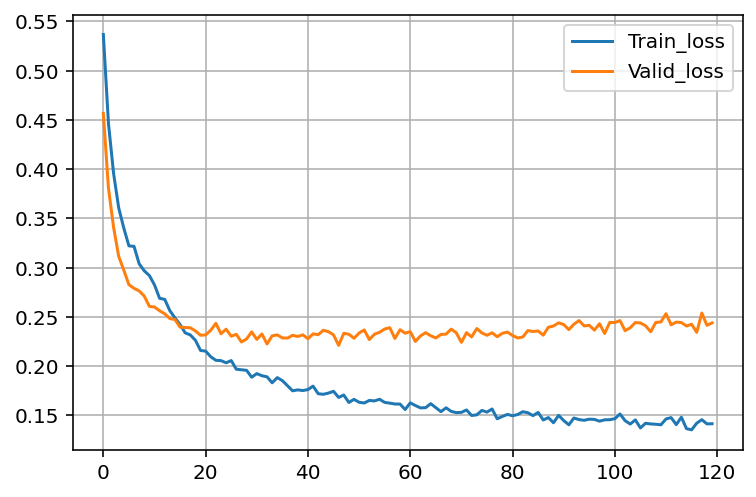

In [ ]:
plt.plot(my_MLP.loss_during_training,label='Train_loss')
plt.plot(my_MLP.valid_loss_during_training,label='Valid_loss')
plt.grid()
plt.legend()

Calculamos la salida para el conjunto de test (log-probabiliad por dato), y evaluamos métricas ...

In [ ]:
out_test = my_MLP.forward(torch.Tensor(W_[idx_test,:])).detach().numpy()

In [ ]:
# Accuracy en test

np.sum(np.argmax(out_test,1)==y_test)/np.shape(y_test)[0]

0.9274475524475524

In [ ]:
out_train = my_MLP.forward(torch.Tensor(W_[idx_train,:])).detach().numpy()

In [ ]:
# Accuracy en train

np.sum(np.argmax(out_train,1)==y_train)/np.shape(y_train)[0]

0.9466921815199563

Curvas ROC y PR ...

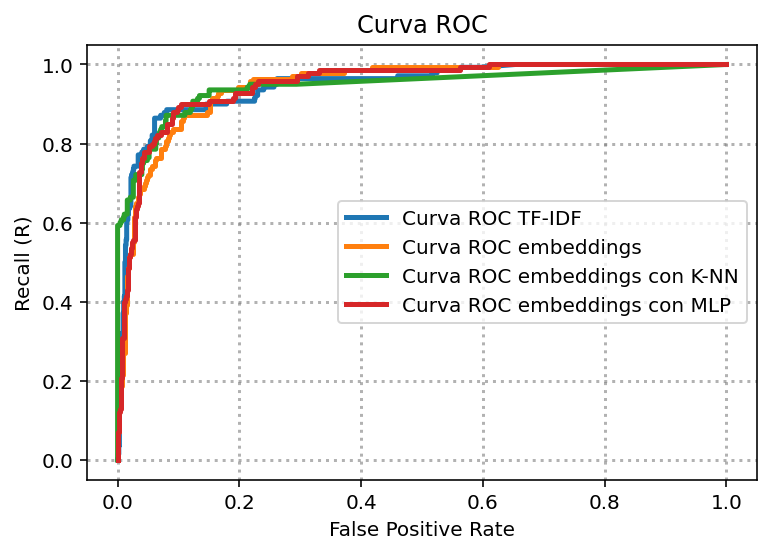

El área bajo la curva ROC de TF-IDF es 0.9481502561183837
El área bajo la curva ROC de embeddings es 0.9464428002276608
El área bajo la curva ROC de embeddings con K-NN es 0.9447958167330679
El área bajo la curva ROC de embeddings con MLP es 0.9489043824701195


In [ ]:
fpr4, recall4, thresholds = metrics.roc_curve(y_test, np.exp(out_test)[:,1], pos_label=1) 

fig,ax = plt.subplots()
plt.plot(fpr,recall,lw=2.5,label='Curva ROC TF-IDF')
plt.plot(fpr2,recall2,lw=2.5,label='Curva ROC embeddings')
plt.plot(fpr3,recall3,lw=2.5,label='Curva ROC embeddings con K-NN')
plt.plot(fpr4,recall4,lw=2.5,label='Curva ROC embeddings con MLP')
plt.legend(loc=7)
plt.grid(b=True, which='major', color='gray', alpha=0.6, linestyle='dotted', lw=1.5)
plt.xlabel('False Positive Rate')
plt.ylabel('Recall (R)')
plt.title('Curva ROC')
plt.show()

area_roc_embbedings_MLP = metrics.roc_auc_score(y_test, np.exp(out_test)[:,1])

print(f"El área bajo la curva ROC de TF-IDF es {area_roc_tf_idf}")
print(f"El área bajo la curva ROC de embeddings es {area_roc_embbedings}")
print(f"El área bajo la curva ROC de embeddings con K-NN es {area_roc_embbedings_knn}")
print(f"El área bajo la curva ROC de embeddings con MLP es {area_roc_embbedings_MLP}")

Podemos comprobar cómo el nuevo clasificador solo consigue una ligera mejora  con respecto a soluciones anteriores. 


# 1.5 Clasificación RNN + Regresión Logística

Finalmente, vamos a comprobar cómo un procesado secuencial de las palabras utilizando una RNN permite una representación vectorial del texto más fiel al contenido, permitiendo una mejora de las prestaciones del clasificador. Tanto es así, que el clasificador será una simple regresión logística sobre el último estado de la RNN.

<img src='http://www.tsc.uc3m.es/~olmos/BBVA/RNN.png' width=800 />


Primero, vamos a normalizar la longitud de las secuencias de texto. Esto es solo un requisito de entrada para la función RNN de pytorch. Una vez obtengamos la secuencia de estados de la RNN, **utilizaremos el estado resultante tras procesar la última palabra del texto**.

In [ ]:
# Calculamos la longitud por texto

longitudes = [len(d) for d in norm_docs]

# Máxima longitud
max_l = np.max(longitudes)

In [ ]:
max_l

35

In [ ]:
# Igualar dataset añadiendo un token "basura" (no se tendrá en cuenta)

garbage_token = nlp('#') # Token basura --> #

norm_docs_eq_length = [norm_docs[d]+[garbage_token]*(max_l-longitudes[d]) for d in range(len(norm_docs))]

# documentos train

docs_train = [norm_docs_eq_length[d] for d in idx_train]

len_train = [longitudes[d] for d in idx_train]

# documentos validación

docs_val = [norm_docs_eq_length[d] for d in idx_val]

len_val = [longitudes[d] for d in idx_val]

# documentos test

docs_test = [norm_docs_eq_length[d] for d in idx_test]

len_test = [longitudes[d] for d in idx_test]

A continuación creamos la clase RNN. A la hora de construir una RNN debemos especificar los siguientes parámetros

* **input_size** - En nuestro caso dimensión de cada word embedding (300)
* **hidden_dim** - La dimensión del estado de la LSTM
* **n_layers** - Número de **LSTMs apiladas**, tal y como se ilustra en la siguiente figura 
* **dropout** - Probabilidad de dropout entre capas (sólo si n_layers>1) 

<img src="https://yiyibooks.cn/__src__/wizard/nmt-tut-neubig-2017_20180721165003_deleted/img/6-5.jpg" width="40%"> 

Se aconseja ver la documentación oficial de la capa [LSTM](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html) para entender todos sus parámetros:

In [ ]:
class RNN(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers,prob=0.5):
        
        
        super().__init__()
        
        self.hidden_dim = hidden_dim
        
        self.input_size = input_size
        
        # Capa LSTM
        # batch_first=True significa que la primera dimensión del tensor de entrada indexa datos distintos
        self.rnn = nn.LSTM(input_size, hidden_dim, n_layers, dropout=prob, batch_first=True)
        
        # last, fully-connected layer
        self.fc1 = nn.Linear(hidden_dim, output_size) 
        
        self.logsoftmax = nn.LogSoftmax(dim=1) 
        
        # Capa dropout 
        
        self.dropout = nn.Dropout(p=prob)

    def forward(self, x, lengths, h0=None):
        
        '''
        
        - x: secuencias de texto, codificadas con word embeddings. Dimensiones (batch_size, seq_length, input_size)
        - lengths: la longitud de cada texto (antes de meter el token de relleno). Se usa para mirar el estado correcto
          para clasificar.
        
        Sobre las dimensiones de los tensores de entrada ...:
        
        - Señal de entrada a RNN tiene dimensiones (batch_size, seq_length, input_size)
        - La inicialización del estado de la RNN tiene dimensiones (n_layers, batch_size, hidden_dim).
          Si se usa None, se inicializa con ceros.
        - La salida de la RNN tiene dimensiones (batch_size, seq_length, hidden_size). 
          Esta salida es el estado de la RNN a lo largo del tiempo para cada dato 

        '''
        
        batch_size = x.size(0) 
        seq_length = x.size(1) 
        
        # Calculamos la salida de la RNN
        # r_out es la secuencia de estados
        r_out, _ = self.rnn(x, h0)
        
        # Usamos el estado correspondiente a procesar la última palabra, antes de meter el relleno.
        # Con el reshape pasamos a dimensiones (batch_ize, hidden_dim)
        
        
        aux=torch.stack([r_out[[d],lengths[d]-1,:] for d in range(batch_size)]).reshape([-1,self.hidden_dim])
        
        # Clasificamos usando una log-softmax
        
        output = self.logsoftmax(self.fc1(self.dropout(aux)))
    
        
        return output


Vamos a ilustrar cómo podemos obtener la salida de la red dados nuestros textos. Por ejemplo, obtengamos la salida de la RNN para los tres primeros textos. El primer paso es obtener las **secuencias de word embeddings** de cada uno de ellos ...

In [ ]:
idx = [1,2,3]
x_input = torch.Tensor([[w.vector for w in norm_docs_eq_length[d]] for d in idx])

In [ ]:
x_input.shape

torch.Size([3, 35, 300])

Instanciamos la clase anterior

In [ ]:
my_RNN = RNN(300,2,20,1)

/Users/olmos/opt/anaconda3/envs/work/lib/python3.6/site-packages/torch/nn/modules/rnn.py:61: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [ ]:
o = my_RNN.forward(torch.Tensor(x_input),[longitudes[d] for d in idx])

In [ ]:
print(torch.exp(o))

tensor([[0.3745, 0.6255],
        [0.5419, 0.4581],
        [0.4204, 0.5796]], grad_fn=<ExpBackward>)


Tal y como hicimos anteriormente, extendemos la clase para añadir un método de entrenamiento. El entrenamiento de RNNs puede ser lento, y se recomienda añadir funcionalidades para explotar hardware de tipo GPU. Un ejemplo puede encontrarse en este [tutorial](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html).

Se han añadido funcionalidades para **salvar la configuración de la red al final de cada época durante el entrenamiento**. Esto nos permitirá recuperar la red que minimiza el error de validación.

In [ ]:
class RNN_with_train(RNN):
    
    def __init__(self,input_size, output_size, hidden_dim, n_layers,prob=0.0,batch_size=50,lr=0.0005,saved_files='./saved_models/RNN_sentiment_analysis'):
        
        super().__init__(input_size, output_size, hidden_dim, n_layers,prob)  
        
        self.lr = lr # Learning Rate
        
        self.optim = optim.Adam(self.parameters(), self.lr) # Optimizador
        
        self.criterion = nn.NLLLoss()               
        
        self.loss_during_training = [] 
        
        self.valid_loss_during_training = [] 
        
        self.batch_size = batch_size
        
        self.saved_files = saved_files
        
        
    def predict_proba(self,docs,lengths,Y=0):
        
        '''
        Este método lo usamos para obtener la salida de la red dado un conjunto de documentos. Si se proporciona etiqueta,
        obtenemos accuracy.
        
        - docs: documentos, en formato lista de spacy tokens. Normalizados con igual longitud añadiendo tokens basura
        - lengths: longitud real de cada texto.
        - Y: Etiquetas
        '''
        
        x_input = torch.Tensor([[w.vector for w in d] for d in docs])
        
        logprobs = self.forward(x_input,lengths).detach().numpy()
            
        accuracy = np.sum(np.argmax(logprobs,1)==Y)/np.shape(Y)[0]
            
        return logprobs,accuracy
            
        
    def fit(self,docs_train,docs_val,Y,Yval,len_train,len_val,epochs=100,print_every=5):
        
        '''
        Método de entrenamiento.
        
        - docs_train, docs_val: documentos de training/validación (secuencias de spacy tokens). 
          Normalizados con igual longitud añadiendo tokens basura
        - len_train/len_val: longitudes reales
        '''
        
        self.print_every = print_every
        
        self.epochs=epochs
        
        # Optimization Loop
        
        self.num_train = len(docs_train) # Num datos de entrenamiento
        
        self.num_batchs = np.floor(self.num_train/self.batch_size) # Numero de batches de training
        
        self.num_val = len(docs_val) # Num datos de validación
        
        self.num_batchs_val = np.floor(self.num_val/self.batch_size) # Numero de batches de validación 
        
        labels = torch.Tensor(Y).type(torch.LongTensor) # Etiquetas training
        
        labelsval = torch.Tensor(Yval).type(torch.LongTensor) # Etiquetas validación
        
        
        for e in range(int(self.epochs)):
            
            self.train() # Dropout activado
            
            # Permutación aleatoria datos
            
            idx = np.random.permutation(self.num_train)
            
            running_loss = 0.
            
            for i in range(int(self.num_batchs)):
                        
                self.optim.zero_grad()  # Ponemos gradientes a cero

                # Ínidices de los datos que entran al batch

                idx_batch = idx[i*self.batch_size:(i+1)*self.batch_size]
                
                # Codificamos entradas como secuencias de embeddings
                
                x_input = torch.Tensor([[w.vector for w in docs_train[d]] for d in idx_batch])
                
                # Calculamos probabilidades por dato

                out = self.forward(x_input,[len_train[d] for d in idx_batch])
                
                # Evaluamos función de coste

                loss = self.criterion(out,labels[idx_batch])
                
                # Guardamos para monitorizar

                running_loss += loss.item()
                
                # Calculamos gradientes

                loss.backward()

                # Limitamos el valor de los gradientes para evitar problemas numéricos (típicos en RNNs)
                nn.utils.clip_grad_norm_(self.parameters(), 2.0)
                
                # Iteración SGD
                
                self.optim.step()
                
            self.loss_during_training.append(running_loss/self.num_batchs)
            
            # Guardamos los parámetros del modelo
            
            torch.save(self.state_dict(), self.saved_files+'_epoch_'+str(e)+'.pth')
            
            # Repetimos para validación, pero sin evaluar gradientes
            
            with torch.no_grad(): 
                
                # set model to evaluation mode
                self.eval()
                
                running_loss = 0.
                
                idx = np.random.permutation(self.num_val)

                running_loss = 0.
                
                for i in range(int(self.num_batchs_val)):
                    
                    idx_batch = idx[i*self.batch_size:(i+1)*self.batch_size] 
                    
                    x_input = torch.Tensor([[w.vector for w in docs_val[d]] for d in idx_batch])

                    out = self.forward(x_input,[len_val[d] for d in idx_batch])

                    loss = self.criterion(out,labelsval[idx_batch])

                    running_loss += loss.item() 
                    
                self.valid_loss_during_training.append(running_loss/self.num_batchs_val)    
                    
                

            if(e % self.print_every == 0): 

                print(f"Training loss after {e} epochs: {self.loss_during_training[-1]}. Validation loss: {self.valid_loss_during_training[-1]}")

Definida la red neuronal y los métodos para su entrenamiento, instaciamos la clase y entrenamos. Utilizamos un estado de la LSTM de 20 dimensiones y una sóla capa LSTM, pero estos parámetro **no se han validado**. HAY MUCHO MARGEN DE MEJORA!

In [ ]:
my_RNN = RNN_with_train(input_size=300,output_size=2,hidden_dim=100,prob=0.6,n_layers=1)

/Users/olmos/opt/anaconda3/envs/work/lib/python3.6/site-packages/torch/nn/modules/rnn.py:61: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.6 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [ ]:
my_RNN.fit(docs_train,docs_val,torch.Tensor(y_train),torch.Tensor(y_val),len_train,len_val,epochs=30,print_every=1)

Training loss after 0 epochs: 0.4196823921105633. Validation loss: 0.28474899629751843
Training loss after 1 epochs: 0.2916486973631872. Validation loss: 0.2574654204977883
Training loss after 2 epochs: 0.25105150676753424. Validation loss: 0.2683091254697906
Training loss after 3 epochs: 0.2198315014782017. Validation loss: 0.21163884508940908
Training loss after 4 epochs: 0.1887149875090547. Validation loss: 0.19287569489743975
Training loss after 5 epochs: 0.1540842975349459. Validation loss: 0.17923260769910282
Training loss after 6 epochs: 0.12018489490633141. Validation loss: 0.16946446005668905
Training loss after 7 epochs: 0.09344038027912786. Validation loss: 0.16546655404898855
Training loss after 8 epochs: 0.07628306882991774. Validation loss: 0.1496648368322187
Training loss after 9 epochs: 0.0660457314081388. Validation loss: 0.16263069616009793
Training loss after 10 epochs: 0.04949897460716024. Validation loss: 0.16282836213294002
Training loss after 11 epochs: 0.0325628

Representamos la evolución de la función de coste en entrenamiento/validación ...

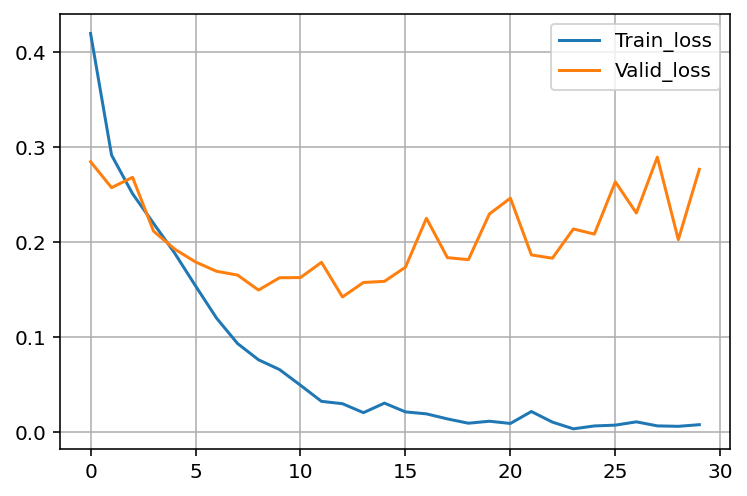

In [ ]:
plt.plot(my_RNN.loss_during_training,label='Train_loss')
plt.plot(my_RNN.valid_loss_during_training,label='Valid_loss')
plt.legend()
plt.grid()

Con el siguiente código, recuperamos los parámetros de la red que minimizan el error de validación ...

In [ ]:
# Época en la que se minimiza el error de validación

idx_min = np.argsort(my_RNN.valid_loss_during_training)

In [ ]:
idx_min[0]

12

Cargamos la red

In [ ]:
state_dict = torch.load(my_RNN.saved_files+'_epoch_'+str(idx_min[0])+'.pth')

my_RNN.load_state_dict(state_dict)

<All keys matched successfully>

Calculamos el accuracy en test y las métricas ROC y curva PR ...

In [ ]:
probs,acc = my_RNN.predict_proba(docs_test,len_test,y_test)

probs = np.exp(probs)

In [ ]:
print(acc)

0.965034965034965


En términos de accuracy superamos a todos los modelos anteriores. 

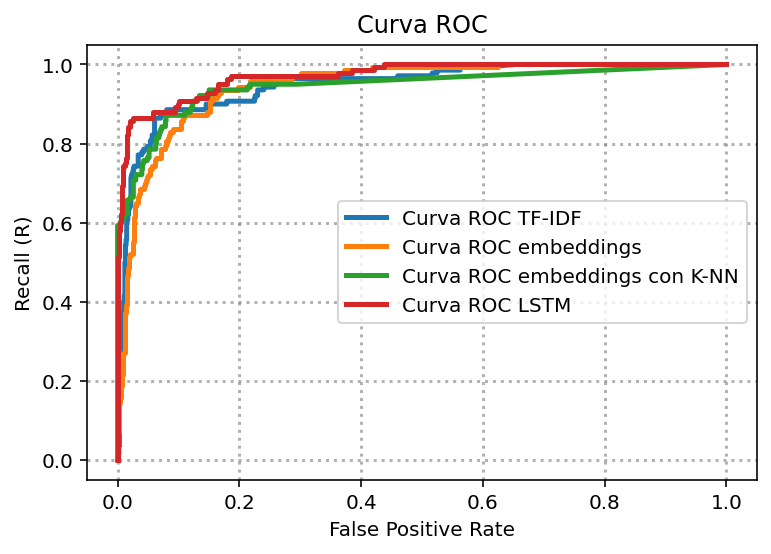

El área bajo la curva ROC de TF-IDF es 0.9481502561183837
El área bajo la curva ROC de embeddings es 0.9464428002276608
El área bajo la curva ROC de embeddings con K-NN es 0.9447958167330679
El área bajo la curva ROC de LSTM es 0.9711795674445076


In [ ]:
fpr4, recall4, thresholds = metrics.roc_curve(y_test, probs[:,1], pos_label=1) 

fig,ax = plt.subplots()
plt.plot(fpr,recall,lw=2.5,label='Curva ROC TF-IDF')
plt.plot(fpr2,recall2,lw=2.5,label='Curva ROC embeddings')
plt.plot(fpr3,recall3,lw=2.5,label='Curva ROC embeddings con K-NN')
plt.plot(fpr4,recall4,lw=2.5,label='Curva ROC LSTM')
plt.legend(loc=7)
plt.grid(b=True, which='major', color='gray', alpha=0.6, linestyle='dotted', lw=1.5)
plt.xlabel('False Positive Rate')
plt.ylabel('Recall (R)')
plt.title('Curva ROC')
plt.show()

area_roc_tf_idf = metrics.roc_auc_score(y_test, LR_with_CV.predict_proba(C[idx_test,:])[:,1])
area_roc_embbedings = metrics.roc_auc_score(y_test, emb_LR_with_CV.predict_proba(W_test)[:,1])
area_roc_embbedings_knn = metrics.roc_auc_score(y_test, knn.predict_proba(W_[idx_test,:])[:,1])
area_roc_LSTM = metrics.roc_auc_score(y_test, probs[:,1])

print(f"El área bajo la curva ROC de TF-IDF es {area_roc_tf_idf}")
print(f"El área bajo la curva ROC de embeddings es {area_roc_embbedings}")
print(f"El área bajo la curva ROC de embeddings con K-NN es {area_roc_embbedings_knn}")
print(f"El área bajo la curva ROC de LSTM es {area_roc_LSTM}")

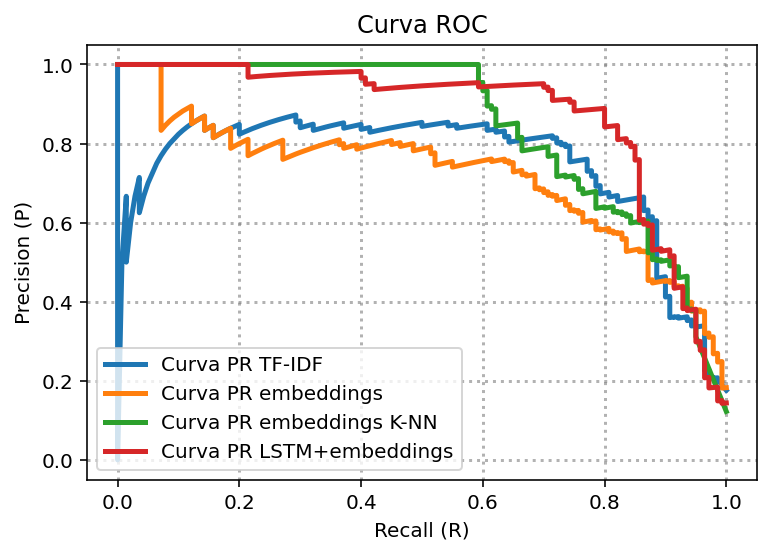

El área bajo la curva PR de TF-IDF es 0.8064507152553245
El área bajo la curva PR de embeddings es 0.7206166463724953
El área bajo la curva PR de embeddings con k-NN es 0.8521587244218084
El área bajo la curva PR de embeddings con LSTM 0.8733330673650296


In [ ]:
P4, R4, thresholds = metrics.precision_recall_curve(y_test, probs[:,1], pos_label=1) 

fig,ax = plt.subplots()
plt.plot(R,P,lw=2.5,label='Curva PR TF-IDF')
plt.plot(R2,P2,lw=2.5,label='Curva PR embeddings')
plt.plot(R3,P3,lw=2.5,label='Curva PR embeddings K-NN')
plt.plot(R4,P4,lw=2.5,label='Curva PR LSTM+embeddings')
plt.legend(loc=3)
plt.grid(b=True, which='major', color='gray', alpha=0.6, linestyle='dotted', lw=1.5)
plt.xlabel('Recall (R)')
plt.ylabel('Precision (P)')
plt.title('Curva ROC')
plt.show()

area_pr_tf_idf = metrics.average_precision_score(y_test, LR_with_CV.predict_proba(C[idx_test,:])[:,1])
area_pr_embbedings = metrics.average_precision_score(y_test, emb_LR_with_CV.predict_proba(W_test)[:,1])
area_pr_embbedings_knn = metrics.average_precision_score(y_test, knn.predict_proba(W_[idx_test,:])[:,1], pos_label=1) 
area_pr_LSTM = metrics.average_precision_score(y_test, probs[:,1], pos_label=1) 

print(f"El área bajo la curva PR de TF-IDF es {area_pr_tf_idf}")
print(f"El área bajo la curva PR de embeddings es {area_pr_embbedings}")
print(f"El área bajo la curva PR de embeddings con k-NN es {area_pr_embbedings_knn}")
print(f"El área bajo la curva PR de embeddings con LSTM {area_pr_LSTM}")

La mejora es evidente sobre todo a la vista de la curva PR.

Es interesante mostrar ejemplos de frases en las que el mejor método hasta ahora (k-NN con medias de word embeddings) falla y el método con LSTMs no. 

In [ ]:
errores_LSTM = np.where(np.argmax(probs,1)!=y_test)[0]

In [ ]:
len(errores_LSTM)

40

In [ ]:
len(errores_k_NN)

71

Podemos ver cómo para un umbral de decisión de 0.5, con LSTMs tenemos 26 fallos menos que con un k-NN con medias de word embeddings.

In [ ]:
errores_LSTM

array([  23,   37,   41,   64,  125,  128,  133,  142,  145,  163,  172,
        190,  316,  348,  377,  383,  385,  415,  449,  452,  455,  481,
        550,  552,  594,  624,  677,  683,  736,  772,  777,  799,  823,
        827,  830,  837,  913,  993, 1014, 1097])

In [ ]:
errores_k_NN

array([   9,   37,   64,   65,  105,  125,  128,  142,  145,  172,  206,
        210,  218,  224,  229,  265,  278,  282,  296,  351,  374,  406,
        415,  430,  442,  449,  452,  455,  477,  505,  511,  536,  550,
        552,  566,  574,  623,  624,  627,  640,  642,  662,  677,  692,
        700,  707,  718,  736,  739,  772,  790,  799,  812,  823,  830,
        837,  871,  879,  892,  893,  906,  930,  937,  967,  970,  989,
        992, 1014, 1045, 1097, 1108])

Imprimamos una de las frases en las que k-NN falla ...

In [ ]:

i = 105

df.iloc[idx_test[i]]['Phrase']

'The company reports a loss for the period of EUR 0.4 mn compared to a loss of EUR 1.9 mn in the corresponding period in 2005 .'

In [ ]:
y_test[i]

0

La anterior frase tiene etiqueta 0 (positiva/neutral). **Sin embargo k-NN falla ya que no considera el orden de las palabras y, desde el punto de vista de un BoW, hay muchas palabras negativas!!**

In [ ]:
knn.predict_proba(W_[idx_test[i],:].reshape([1,-1]))

array([[0.38920933, 0.61079067]])

Sin embargo, el procesado secuencial de LSTM sí permite clasificar correctamente esta frase ...

In [ ]:
probs[i]

array([0.92012984, 0.07987007], dtype=float32)

# 2 Clasificación multi-clase

Finalmente, vamos a ilustrar cómo en el caso de clasificación multi-clase, usando las tres etiquetas originales, de nuevo WE + LSTMs + Regresión Logística alcanza el mejor resultado ...

In [ ]:
# Separamos train de test
idx_train, idx_test, y_train_multiclass, y_test_multiclass = train_test_split(idx_data, labels, test_size=0.2, random_state=0)

# Separamos train de val
idx_train, idx_val, y_train_multiclass, y_val_multiclass = train_test_split(idx_train, y_train_multiclass, test_size=0.2, random_state=0)

rango_C = np.logspace(-3, 3, 20)  # Rango C en escala logarítmica (base 10). Esto es, 20 puntos desde 10^3, a 10^3.
diccionario_parametros = [{'C': rango_C}]   
nfold = 10 # Número de particiones train/validación

""" Ajusto C por validación cruzada
El optimizador por defecto ('lbfgs') no acepta regularización l1. 
Usamos 'liblinear' siguiendo las recomendaciones de la librería.
"""
LR_with_CV  = GridSearchCV(estimator=LR(penalty='l1',max_iter=1e08,solver='liblinear'),
                                  param_grid=diccionario_parametros,cv=nfold)
# Entrenar el modelo
LR_with_CV.fit(C[idx_train,:],y_train_multiclass)   

print("El mejor parámetro C es {0:.2f}".format(LR_with_CV.best_params_['C']))
                        
# Score de claisficación en train/test
accuracy_train = LR_with_CV.score(C[idx_train,:],y_train_multiclass)   
accuracy_test = LR_with_CV.score(C[idx_test,:],y_test_multiclass)  

print("Accuracy train {0:.2f}%. Accuracy test {1:.2f}%\n".format(accuracy_train*100, accuracy_test*100))

El mejor parámetro C es 12.74
Accuracy train 99.07%. Accuracy test 88.64%



In [ ]:
# Entrenamiento k-NN con validación de vecinos y ponderación de distancias
K_max = 15
rango_K = np.arange(1, K_max+1)
nfold = 10
# Define a dictionary with the name of the parameters to explore as a key and the ranges to explores as value
diccionario_parametros = [{'n_neighbors': rango_K,'weights':['uniform','distance']}]

# Validación cruzada con GridSearchCV
knn = GridSearchCV(estimator=KNeighborsClassifier( ), param_grid=diccionario_parametros,cv=nfold)
# Entrenamiento
knn.fit(W_[idx_train,:],y_train_multiclass)
# Test
accuracy_train_knn = knn.score(W_[idx_train,:],y_train_multiclass)
accuracy_test_knn = knn.score(W_[idx_test,:],y_test_multiclass)

print("El número de vecinos seleccionado es k={0:d}".format(knn.best_params_['n_neighbors']))
print("Accuracy train {0:.2f}%. Accuracy test {1:.2f}%\n".format(accuracy_train_knn*100, accuracy_test_knn*100))

El número de vecinos seleccionado es k=12
Accuracy train 100.00%. Accuracy test 85.66%



Text(0.5, 1.0, 'Matrix confusión, codificación embeddings')

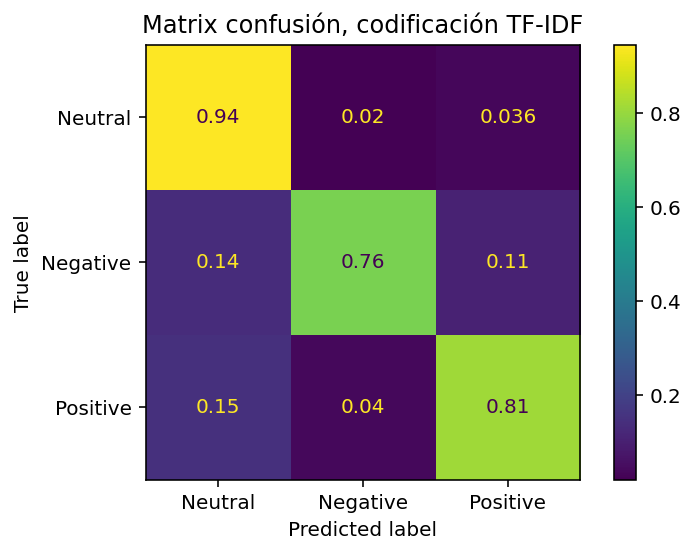

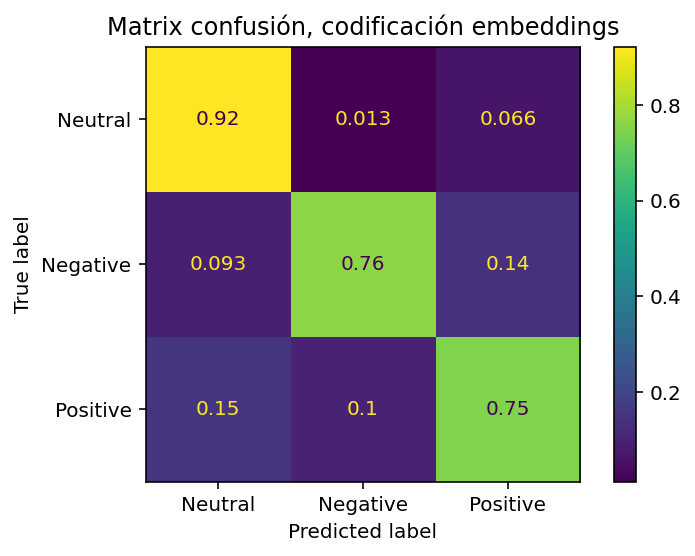

In [ ]:
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(LR_with_CV, C[idx_test,:], y_test_multiclass,normalize='true',display_labels=['Neutral','Negative','Positive'])
plt.title('Matrix confusión, codificación TF-IDF')

plot_confusion_matrix(knn, W_[idx_test,:], y_test_multiclass,normalize='true',display_labels=['Neutral','Negative','Positive'])
plt.title('Matrix confusión, codificación embeddings')

In [ ]:
docs_train = [norm_docs_eq_length[d] for d in idx_train]

len_train = [longitudes[d] for d in idx_train]

docs_val = [norm_docs_eq_length[d] for d in idx_val]

len_val = [longitudes[d] for d in idx_val]

docs_test = [norm_docs_eq_length[d] for d in idx_test]

len_test = [longitudes[d] for d in idx_test]

Reultizamos la clase `RNN_with_train` que construímos anteriormente, especificando ahora `output_size=3`, puesto que tenemos tres etiquetas ...

In [ ]:
my_RNN_3_class = RNN_with_train(input_size=300,output_size=3,hidden_dim=100,n_layers=1,saved_files='./saved_models/RNN_sentiment_analysis_multiclass',prob=0.6)

/Users/olmos/opt/anaconda3/envs/work/lib/python3.6/site-packages/torch/nn/modules/rnn.py:61: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.6 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [ ]:
my_RNN_3_class.fit(docs_train,docs_val,torch.Tensor(y_train_multiclass),torch.Tensor(y_val_multiclass),len_train,len_val,epochs=20,print_every=2)

Training loss after 0 epochs: 0.8620896347581524. Validation loss: 0.6702586942248874
Training loss after 2 epochs: 0.5581810845904154. Validation loss: 0.4958620352877511
Training loss after 4 epochs: 0.41432270979228086. Validation loss: 0.41276758909225464
Training loss after 6 epochs: 0.3047442046338565. Validation loss: 0.3615122429198689
Training loss after 8 epochs: 0.22177070318019554. Validation loss: 0.3882118910551071
Training loss after 10 epochs: 0.16991783010020647. Validation loss: 0.3340480708413654
Training loss after 12 epochs: 0.12454959066355065. Validation loss: 0.3424779396090243
Training loss after 14 epochs: 0.09687848141646549. Validation loss: 0.3540889583528042
Training loss after 16 epochs: 0.08014323909396995. Validation loss: 0.35363705746001667
Training loss after 18 epochs: 0.04963407439677275. Validation loss: 0.386444585190879


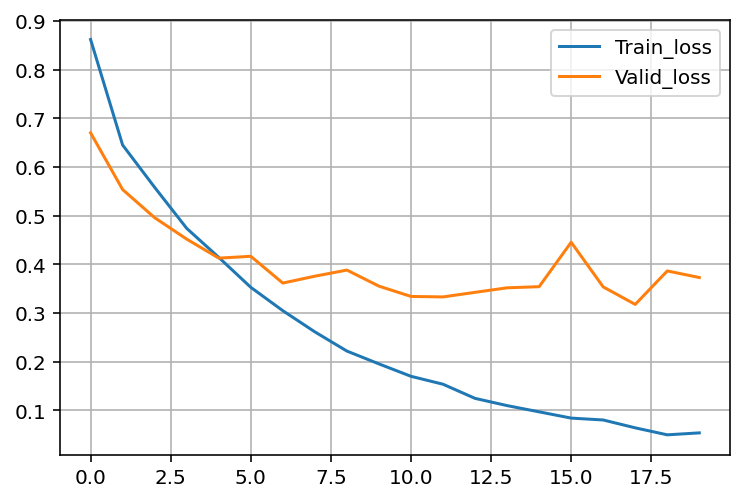

In [ ]:
plt.plot(my_RNN_3_class.loss_during_training,label='Train_loss')
plt.plot(my_RNN_3_class.valid_loss_during_training,label='Valid_loss')
plt.grid()
plt.legend()

Recuperamos la red en el mínimo de la función de coste en validación ...

In [ ]:
idx_min = np.argsort(my_RNN_3_class.valid_loss_during_training)

In [ ]:
idx_min[0]

17

In [ ]:
state_dict = torch.load(my_RNN_3_class.saved_files+'_epoch_'+str(idx_min[0])+'.pth')

my_RNN_3_class.load_state_dict(state_dict)

<All keys matched successfully>

In [ ]:
probs,acc = my_RNN_3_class.predict_proba(docs_test,len_test,y_test_multiclass)

In [ ]:
print(acc)

0.9038461538461539


In [ ]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test_multiclass, np.argmax(probs,1))

cm /np.sum(cm,1)

array([[0.96011396, 0.05714286, 0.06622517],
       [0.02421652, 0.82142857, 0.02649007],
       [0.05840456, 0.11428571, 0.81125828]])